<h1>The Most Environmentally Healthy Neighborhood in Pittsburgh</h1>

<h2>Introduction</h2>

<p>Each neighborhood in Pittsburgh has its own unique appeal but most people can agree that the quality of the environment is a major contributing factor when considering a place to live. Not many people want to live next to a polluted river or breath in polluted air and so we figured that by examining the environmental factors of some Pittsburgh neighborhoods we could determine the best neighborhood in Pittsburgh as the one with the best environmental qualities. As sub-metrics we chose to look at air quality, illegal dump site locations, and _X_ quality. We chose these sub-metrics because they are key attributes to describing the overal environmental quality of any neighborhood.</p>

<!-- Air Quality Data analyzed by: Brian Hutton -->
<h3>Air Quality Data</h3>

<p>To measure the quality of each neighborhoods air, I chose to look at their Air Quality Indexes (AQI's). The web database, AirNow (a partner with the US Environmental Protection Agency), reports official US Air Quality Indexes which are described as: <blockquote>A color-coded index designed to communicate whether air quality is healthy or unhealthy for you.</blockquote>Lower AQI values indicate better quality air while higher indexes indicate more air pollution and thus lower air quality. S</p>

<h4><a href="https://www.airnow.gov/aqi/aqi-basics/">AirNow's AQI Table</a></h4>
<table>
	<tr>
		<th>Daily AQI Color</th>
		<th>Levels of Concern</th>
		<th>Values of Index</th>
		<th>Description of Air Quality</th>
	</tr>
	<tr style="background-color: #00e400;">
		<td>Green</td>
		<td>Good</td>
		<td>0 to 50</td>
		<td>Air quality is satisfactory, and air pollution poses little or no risk.</td>
	</tr>
	<tr style="background-color: #ffff00;">
		<td>Yellow</td>
		<td>Moderate</td>
		<td>51 to 100</td>
		<td>Air quality is acceptable. However, there may be a risk for some people, particularly those who are unusually sensitive to air pollution.</td>
	</tr>
	<tr style="background-color: #ff7e00; color: white;">
		<td>Orange</td>
		<td>Unhealthy for Sensitive Groups</td>
		<td>101 to 150</td>
		<td>Members of sensitive groups may experience health effects. The general public is less likely to be affected.</td>
	</tr>
	<tr style="background-color: #ff0000; color: white;">
		<td>Red</td>
		<td>Unhealthy</td>
		<td>151 to 200</td>
		<td>Some members of the general public may experience health effects; members of sensitive groups may experience more serious health effects.</td>
	</tr>
	<tr style="background-color: #8f3f97; color: white;">
		<td>Purple</td>
		<td>Very Unhealthy</td>
		<td>201 to 300</td>
		<td>Health alert: The risk of health effects is increased for everyone.</td>
	</tr>
	<tr style="background-color: #7e0023; color: white;">
		<td>Maroon</td>
		<td>Hazardous</td>
		<td>301 and higher</td>
		<td>Health warning of emergency conditions: everyone is more likely to be affected.</td>
	</tr>
</table>
<br>

<h4><a href="https://data.wprdc.org/dataset/allegheny-county-air-quality/resource/4ab1e23f-3262-4bd3-adbf-f72f0119108b?inner_span=True">AQI Data Source</a></h4>
<p> The data set I used for Air Quality Indexes data came from the <a href="http://www.wprdc.org/">Western Pennsylvania Regional Data Center</a>. The Western Pennsylvania Regional Data Center hosts many datasets gathered by public sector agencies, academic institutions, and non-profit organizations. Specifically, this <a href="https://data.wprdc.org/dataset/allegheny-county-air-quality/resource/4ab1e23f-3262-4bd3-adbf-f72f0119108b?inner_span=True">data set</a> features air quality data collected from the Allegheny Health Department's air quality monitors which are placed in 15 different areas in Pittsburgh and its surrounding areas.</p>

Specifically the dataset I used contains air quality for the following 15 neighborhoods/regions:

• Lawrenceville
• Flag Plaza
• Harrison Township
• Avalon
• Lincoln
• South Fayette
• North Braddock
• Parkway East
• Liberty 2
• Lawrenceville 2
• Glassport High Street
• Liberty
• Clairton
• West Mifflin
• Pittsburgh

 Among these fifteen regions, the average AQI(Air Quality Index) was 21.62

Lawrenceville  =  38.13
Flag Plaza  =  9.95
Harrison Township  =  24.32
Avalon  =  21.3
Lincoln  =  35.11
South Fayette  =  20.46
North Braddock  =  18.02
Parkway East  =  22.23
Liberty 2  =  32.26
Lawrenceville 2  =  3.12
Glassport High Street  =  17.1
Liberty  =  18.7
Clairton  =  7.27
West Mifflin  =  6.34
Pittsburgh  =  28.62

Since Lawrenceville comes up as both the highest and lowest AQI, we will consider "West Mifflin" as the region in Pittsburgh with the lowest AQI.



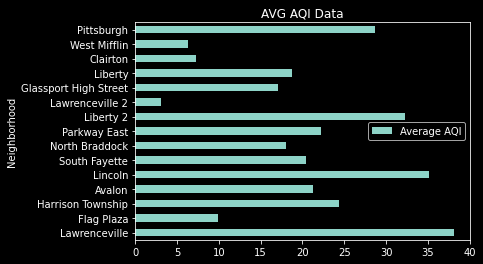

In [3]:
# Air Quality data analyzed by: Brian Hutton

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import geopandas
import seaborn as sns
%matplotlib inline

# Read in AQI data file from WPRDC
aqi_data = pd.read_csv("daily_aqi_data.csv", index_col="date", parse_dates=True)

# Get list of neighborhoods in dataset
neighborhood_names = aqi_data['site'].unique()
print("Specifically the dataset I used contains air quality for the following {} neighborhoods/regions:\n".format(len(neighborhood_names)))

# Print list of neighborhooods in dataset
for neighborhood in neighborhood_names:
    print("•", neighborhood)
    
print("\n Among these fifteen regions, the average AQI(Air Quality Index) was {0}\n".format(round(aqi_data['index_value'].mean(), 2)))

# create a sub-dataset for each neighborhood
neighborhood_sets = []
for neighborhood in neighborhood_names:
    neighborhood_sets.append(aqi_data[aqi_data['site'] == neighborhood])

# we can index to a specific neighborhoods dataset by using the neighborhoods index in the neighborhood_names list
# avg_aqi contains average air quality for each neighborhood
avg_aqi = []
for i in range(len(neighborhood_sets)):
    avg = round(neighborhood_sets[i]['index_value'].sum() / len(neighborhood_sets[i]['index_value']),2)
    avg_aqi.append(avg)
    
for i in range(len(neighborhood_names)):
    print(neighborhood_names[i], " = ", avg_aqi[i])
    
# Forming new simpler dataframe with just neighborhood names and their corresponding averages
neighborhood_data = {"Neighborhood":neighborhood_names, "Average AQI":avg_aqi}
avg_neighborhood_aqi = pd.DataFrame(neighborhood_data)

# choosing style for plot
# plt.style.available
# plt.style.use('ggplot')
plt.style.use('dark_background')

# plotting average AQI data for each neighborhood
avg_neighborhood_aqi.plot.barh(title="AVG AQI Data", x="Neighborhood", y="Average AQI")

print("\nSince Lawrenceville comes up as both the highest and lowest AQI, we will consider \"West Mifflin\" as the region in Pittsburgh with the lowest AQI.\n")

# map plotting with geopandas


<h3>Illegal Dump Site Data</h3>
<p> ~~Aziz~~ add a description of what describing factors you chose to look at for Illegal Dump Site data</p>

The dataset we used contains air quality for the following 73 Cities/regions:

• Pittsburgh
• Avalon
• Plum Borough
• Oakmont
• Bell Acres
• Bellevue
• Bethel Park
• Millvale
• Boston
• Braddock
• Buena Vista
• Carnegie
• Blawnox
• Clairton
• Collier
• Crescent
• Dravosburg
• Duquesne
• East Deer Township
• Edgeworth
• Elizabeth
• Findlay
• Forward
• Fox Chapel
• Freeport
• Gibsonia
• Glassport/Lincoln
• Glenfield
• Hampton
• Harmarville
• Indiana/Hampton
• Jefferson Hills
• Kennedy Township
• Leet Township
• Liberty
• Lincoln
• Marshall
• McCandless
• McKees Rocks
• McKeesport
• Monroeville
• Moon Twp.
• Mt Lebanon
• Natrona
• Neville Island
• Coraopolis
• New Homestead
• North Fayette
• McCandless Twp
• North Versailles
• O'Hara Township
• Municipal
• Penn Hills
• Pine Township
• Rankin
• Robinson
• Sewickley
• Sewickley Heights
• Shaler
• Sharpsburg
• South Fayette
• Springdale
• Swissvale
• Turtle Creek
• Verona
• West Deer Township
• West Mifflin
• West View
• Whitaker
• White Oak

<AxesSubplot:ylabel='City'>

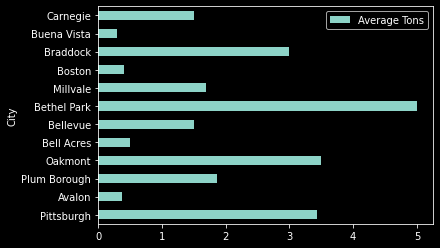

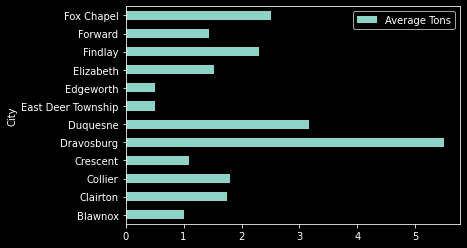

In [4]:
dump_data = pd.read_csv("C:\\Users\\aziz1\\Downloads\\illegaldumpsites.csv")
dump_data['estimated_tons'] = pd.to_numeric(dump_data['estimated_tons'])
#dump_data.City.unique()

city_names = dump_data.City.unique()
print("The dataset we used contains air quality for the following {} Cities/regions:\n".format(len(city_names)))

for city in city_names:
    print("•", city)

print("\nThe average displaced illegal dump for all Cities is {0} tons\n".format(round(dump_data['estimated_tons'].mean(), 2)))

city_sets = []
for city in city_names:
    city_sets.append(dump_data[dump_data['City'] == city])
    
avg_tons = []
for i in range(len(city_sets)):
    avg = round(city_sets[i]['estimated_tons'].sum()/len(city_sets[i]['estimated_tons']),2)
    avg_tons.append(avg)

for i in range(len(city_names)):
    print(city_names[i], " = ", avg_tons[i])

city_data = {"City":city_names, "Average Tons":avg_tons}
avg_city_tons = pd.DataFrame(city_data)

#Sub-dataset 1
city1 = ['Pittsburgh', 'Avalon', 'Plum Borough', 'Oakmont', 'Bell Acres', 'Bellevue', 'Bethel Park', 'Millvale', 'Boston', \
         'Braddock', 'Buena Vista', 'Carnegie'] 
avg2 = avg_city_tons[avg_city_tons.City.isin(city1)]

#Sub-dataset 2
city2 = ['Blawnox', 'Clairton', 'Collier', 'Crescent', 'Dravosburg', 'Duquesne', 'East Deer Township', 'Edgeworth', \
         'Elizabeth', 'Findlay', 'Forward', 'Fox Chapel']
avg3 = avg_city_tons[avg_city_tons.City.isin(city2)]

#Sub-dataset 3
city3 = ['Freeport', 'Gibsonia', 'Glassport/Lincoln', 'Glenfield', 'Hampton', 'Harmarville', 'Indiana/Hampton', \
         'Jefferson Hills', 'Kennedy Township', 'Leet Township', 'Liberty', 'Lincoln']
avg4 = avg_city_tons[avg_city_tons.City.isin(city3)]

#Sub-dataset 4
city4 = ['Marshall', 'McCandless', 'McKees Rocks', 'McKeesport','Monroeville', 'Moon Twp.', 'Mt Lebanon', 'Natrona', \
         'Neville Island', 'Coraopolis', 'New Homestead', 'North Fayette']
avg5 = avg_city_tons[avg_city_tons.City.isin(city4)]

#Sub-dataset 5
city5 = ['McCandless Twp', 'North Versailles', "O'Hara Township",'Municipal', 'Penn Hills', 'Pine Township', 'Rankin', \
         'Robinson', 'Sewickley', 'Sewickley Heights', 'Shaler', 'Sharpsburg']
avg6 = avg_city_tons[avg_city_tons.City.isin(city5)]

#Sub-dataset 6
city6 = ['South Fayette', 'Springdale', 'Swissvale', 'Turtle Creek','Verona', 'West Deer Township', 'West Mifflin', \
         'West View', 'Whitaker', 'White Oak', 'Wilkins', 'Wilkinsburg','Wilkinsburg/Penn Hills']
avg7 = avg_city_tons[avg_city_tons.City.isin(city6)]

plt.style.use('dark_background')
avg2.plot.barh(x="City", y="Average Tons")
avg3.plot.barh(x="City", y="Average Tons")

<h3>Eric's Metric</h3>
<p> ~~Eric~~ add a description of what describing factors you chose to look at for the metric you chose to analyze</p>

In [1]:
# Eric add the code you used to analyze your dataset, don't forget to upload the file you did analysis on

<h3>Resources</h3>
<!-- everyone add the resources they used here -->
<ul>
    <li>Air Quality Dataset from: <a href="https://data.wprdc.org/dataset/allegheny-county-air-quality/resource/4ab1e23f-3262-4bd3-adbf-f72f0119108b?inner_span=True">WPRDC</a></li>
    <li>Air Quality Information from <a href="https://www.airnow.gov/aqi/aqi-basics/">AirNow</a></li>
    <li>Aziz's resources</li>
    <li>Eric's resources</li>
</ul>